In [4]:
!git clone https://github.com/beckhamtoh/char-llm-assignment.git
%cd char-llm-assignment

Cloning into 'char-llm-assignment'...
remote: Enumerating objects: 122, done.
remote: Counting objects: 100% (122/122), done.
remote: Compressing objects: 100% (81/81), done.
remote: Total 122 (delta 54), reused 89 (delta 28), pack-reused 0 (from 0)
Receiving objects: 100% (122/122), 31.13 MiB | 19.34 MiB/s, done.
Resolving deltas: 100% (54/54), done.
/content/char-llm-assignment


In [5]:
# Enable autoreload of local Python modules (e.g., models)
# %load_ext autoreload
# %autoreload 2

# manual reload for local modules
import importlib

In [6]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import numpy as np
import jax
import jax.numpy as jnp
import optax
import time

# local imports
import models.models as models
import util.generation as generation


In [7]:
# initialize the jax random key
key = jax.random.key(0)

# Load data

In [8]:
# load the ./data/text8_train.txt and ./data/text8_test.txt files
with open("./data/text8_train.txt", "r") as f:
    train_text = f.read()
with open("./data/text8_test.txt", "r") as f:
    test_text = f.read()

# print the length of the training text and test text
print(f"Length of training text: {len(train_text):_} characters")
print(f"Length of test text: {len(test_text):_} characters")

Length of training text: 90_000_000 characters
Length of test text: 5_000_000 characters


In [9]:
# Build vocabulary (lowercase + space + a few punctuations)
char_set = list("abcdefghijklmnopqrstuvwxyz ")
char_to_int = {ch:i for i,ch in enumerate(char_set)}
int_to_char = {i:ch for ch,i in char_to_int.items()}

def encode(s):
    """Encode string to array of integers"""
    ids = [char_to_int[c] for c in s]
    return np.array(ids, dtype=np.uint8)  # use np.uint8 to save space

In [10]:
# encode the text
train_text_int = encode(train_text)
test_text_int = encode(test_text)

In [11]:
# sanity check: display a few random characters from the training text
T = 128
for _ in range(5):
    # choose random position in text
    N = np.random.randint(low=0, high=len(train_text)-T)
    print(train_text[N:N+T])
    print()

l league teams one nine one nine establishments the cincinnati bengals are a professional american football team based in cincin

rd monday in january in the united states mother in law s day fourth sunday in october where patriot s day third monday in april

he system from time to time to remove salt build up this may be checked with a ppm meter a good average reading would be about o

 major stumbling blocks in this was that the lm lifeboat was equipped to sustain two people for two days and it would now have t

the meaning of a sentence rather than the actual sentence structure in particular speakers of leet are fond of verbing nouns tur



# Create a basic Transformer model

In [12]:
def create_train_state(rng, vocab_size=27, d_model=64, n_layers=6, n_heads=8, max_len=128):
    # create a basic Transformer model
    model = models.DecoderOnlyTransformer(vocab_size, d_model, n_layers, n_heads, max_len)
    # create a dummy input for initialization
    dummy = jnp.zeros((1, min(16, max_len)), dtype=jnp.int32)
    # pass the dummy input to the model to initialize the parameters
    params = model.init({"params": rng}, dummy)["params"]
    return model, params

In [35]:
# vocab size
vocab_size= len(char_set)

# internal model dimensions
d_model=512

# number of attention heads
n_heads=8

# number of Transformer layers
n_layers=4

# maximum sequence length
max_len=128

model, params = create_train_state(key, vocab_size, d_model, n_layers, n_heads, max_len)

In [36]:
# compute the number of parameters
def count_params(params):
    return sum(x.size for x in jax.tree_util.tree_leaves(params))
print(f"Number of parameters: {count_params(params):_}")

Number of parameters: 12_695_552


In [15]:
# sanity check: create a batch of data & run a forward pass
B, T = 4, 32
batch = jax.random.randint(
    key=key,
    shape=(B, T), minval=0, maxval=len(char_set))
logits = model.apply({"params": params}, batch)

print("batch shape:", batch.shape)  # (B, T)
print("logits shape:", logits.shape)  # (B, T, vocab_size)

batch shape: (4, 32)
logits shape: (4, 32, 27)


# Loss function

In [16]:
@jax.jit
def loss_and_metrics(logits, targets):
    """Compute cross-entropy loss and accuracy.

    Assumes `targets` contains only valid integer class ids in [0, V-1] (no -1 ignore tokens).

    Args:
      logits: (B, T, V) float array of unnormalized scores.
      targets: (B, T) integer array with ground-truth class ids.

    Returns:
      loss: scalar average cross-entropy over all positions.
      metrics: dict with keys "loss" and "acc" (both scalars).
    """
    # Flatten batch/time dims so optax works on shape (N, V) and (N,)
    vocab = logits.shape[-1]
    flat_logits = logits.reshape(-1, vocab)
    flat_targets = targets.reshape(-1)

    # Per-position cross-entropy, then mean over all positions
    per_pos = optax.softmax_cross_entropy_with_integer_labels(flat_logits, flat_targets)
    loss = per_pos.mean()

    # prediction over all positions
    preds = jnp.argmax(logits, axis=-1)  # (B, T)

    # compute accuracy over only the last position
    is_match = preds == targets

    # Accuracy over all positions
    acc_all = jnp.mean(is_match.astype(jnp.float32))

    # Accuracy over only last position
    acc_last = jnp.mean(is_match.astype(jnp.float32)[:,-1])

    return loss, {"loss": loss, "acc": acc_all, "acc_last": acc_last}

# Optimization step:

In [17]:
# create an update function
def train_step(params, opt_state, x, y, tx):
    """Single optimization step using optax optimizer.

    Args:
      params: pytree of model parameters.
      opt_state: optax optimizer state corresponding to `params`.
      x: (B, T) int array input tokens.
      y: (B, T) int array target tokens.
      tx: optax.GradientTransformation (already initialized).

    Returns:
      new_params: updated parameters after one gradient step.
      new_opt_state: updated optimizer state.
      metrics: dict of scalar metrics (loss, acc).
    """
    def loss_fn(params):
        logits = model.apply({"params": params}, x)
        loss, metrics = loss_and_metrics(logits, y)
        return loss, metrics

    # compute gradients (loss is scalar, metrics is auxiliary)
    (loss, metrics), grads = jax.value_and_grad(loss_fn, has_aux=True)(params)

    # optax update: compute parameter updates and new optimizer state
    updates, new_opt_state = tx.update(grads, opt_state, params)
    new_params = optax.apply_updates(params, updates)
    return new_params, new_opt_state, metrics

# jit: last argument should be static because it is an object
train_step = jax.jit(train_step, static_argnames=("tx",))

# Batch creation:

In [18]:
# create a batch from the training data
def get_batch(text_int, B, T):
    """Create a random batch of data from text_int.

    Args:
      text_int: 1D array of token ids.
      B: batch size (number of sequences).
      T: sequence length (number of tokens per sequence).

    Returns:
      x: (B, T) int array input tokens.
      y: (B, T) int array target tokens.
    """
    # choose random starting indices for each sequence in the batch
    ix = np.random.randint(0, len(text_int) - T, size=B)
    # inputs are text from i to i+T
    x = np.stack([text_int[i:i+T] for i in ix])
    # targets are text from i+1 to i+T+1
    y = np.stack([text_int[i+1:i+T+1] for i in ix])
    return jnp.array(x, dtype=jnp.int32), jnp.array(y, dtype=jnp.int32)

## **Experiment 3: LR + Model Dimensions + N Layers**
-----> Ran out of compute

In [ ]:
import itertools

# ---- CONFIG ----
learning_rates = [1e-3, 1e-4, 1e-5]
model_dims = [256, 512, 768]
num_layers_list = [4, 6, 8]

runtime_limit = 120        # seconds (~2min)
full_niter = 50_000       # total planned iterations for schedule
record_interval = 20

B, T = 256, 64
B_test, T_test = 1034, 32

experiment_results = []

# cosine warmup schedule (full schedule)
warmup_steps = int(0.1 * full_niter)
decay_steps  = full_niter - warmup_steps

def make_full_cosine(base_lr):
    def schedule(step):
        s = jnp.minimum(step, 1_000_000)
        warmup_lr = base_lr * (s / warmup_steps)
        cosine_decay = 0.5 * (1 + jnp.cos(jnp.pi * (s - warmup_steps) / decay_steps))
        cosine_lr = base_lr * cosine_decay
        return jnp.where(s < warmup_steps, warmup_lr, cosine_lr)
    return schedule


# ---- GRID SEARCH ----
for lr, dim, n_layers in itertools.product(learning_rates, model_dims, num_layers_list):
    print(f"=== Running lr={lr}, dim={dim}, n_layers={n_layers} ===")

    # Initialize model with the given parameters
    model, params_exp = create_train_state(key, vocab_size, dim, n_layers, n_heads, max_len) # dim, n_layers are newly defined

    schedule_fn = make_full_cosine(lr)
    tx = optax.chain(
        optax.clip_by_global_norm(1.0),
        optax.adamw(learning_rate=schedule_fn, weight_decay=1e-4)
    )
    opt_state_exp = tx.init(params_exp)

    # histories
    train_loss_history, train_acc_history, train_acc_last_history = [], [], []
    test_loss_history,  test_acc_history,  test_acc_last_history  = [], [], []
    lr_history = []
    time_history, time_test_history = [], []

    time_start = time.time()
    step = 0

    while time.time() - time_start < runtime_limit:

        # train batch
        input, target = get_batch(train_text_int, B, T)
        params_exp, opt_state_exp, metrics = train_step(params_exp, opt_state_exp, input, target, tx)

        # log train
        train_loss_history.append(float(metrics['loss']))
        train_acc_history.append(float(metrics['acc']))
        train_acc_last_history.append(float(metrics['acc_last']))
        time_history.append(time.time() - time_start)

        # numeric LR
        current_lr = float(schedule_fn(step))
        lr_history.append(current_lr)

        # periodic test
        if step % (record_interval * 5) == 0:
            test_input, test_target = get_batch(test_text_int, B_test, T_test)
            test_logits = model.apply({"params": params_exp}, test_input)
            test_loss, test_metrics = loss_and_metrics(test_logits, test_target)

            test_loss_history.append(float(test_loss))
            test_acc_history.append(float(test_metrics['acc']))
            test_acc_last_history.append(float(test_metrics['acc_last']))
            time_test_history.append(time.time() - time_start)

        step += 1

    print(f"done: lr={lr}, dim={dim}, n_layers={n_layers}, steps={step}")

    experiment_results.append({
        'lr': lr,
        'dim': dim,
        'n_layers': n_layers,
        'steps': step,
        'train_loss': train_loss_history,
        'train_acc': train_acc_history,
        'train_acc_last': train_acc_last_history,
        'test_loss': test_loss_history,
        'test_acc': test_acc_history,
        'test_acc_last': test_acc_last_history,
        'lr_history': lr_history,
        'train_time': time_history,
        'test_time': time_test_history
    })

print("Grid search finished!")

=== Running lr=0.001, dim=256, n_layers=4 ===
done: lr=0.001, dim=256, n_layers=4, steps=821
=== Running lr=0.001, dim=256, n_layers=6 ===


## **Experiment 2: Batch Size**
For optimising batch size, I limited the no. of iterations instead of the runtime (because a larger batch takes a longer time).

Based on the results of Experiment 1, I will use lr=0.001. I also changed the model parameters (d_model=256-->512, n_layers=2-->4) for this experiment.

In [44]:
# ---- CONFIG ----
lr = 1e-3                 # fixed learning rate
full_niter = 100_000      # your true final planned training length
record_interval = 20
step_limit = 2000

# batch sizes to experiment with
batch_sizes = [32, 64, 128, 256]

B_test, T_test = 1034, 32

experiment_results = []

# cosine warmup schedule (full schedule)
warmup_steps = int(0.1 * full_niter)
decay_steps  = full_niter - warmup_steps

def make_full_cosine(base_lr):
    def schedule(step):
        s = jnp.minimum(step, 1_000_000)
        warmup_lr = base_lr * (s / warmup_steps)
        cosine_decay = 0.5 * (1 + jnp.cos(jnp.pi * (s - warmup_steps) / decay_steps))
        cosine_lr = base_lr * cosine_decay
        return jnp.where(s < warmup_steps, warmup_lr, cosine_lr)
    return schedule

for B in batch_sizes:
    print(f"=== running batch_size={B} ===")

    params_exp = params  # reset model

    schedule_fn = make_full_cosine(lr)
    tx = optax.chain(
        optax.clip_by_global_norm(1.0),
        optax.adamw(learning_rate=schedule_fn, weight_decay=1e-4)
    )
    opt_state_exp = tx.init(params_exp)

    # histories
    train_loss_history, train_acc_history, train_acc_last_history = [], [], []
    test_loss_history,  test_acc_history,  test_acc_last_history  = [], [], []
    lr_history = []
    time_history, time_test_history = [], []

    time_start = time.time()
    step = 0

    while step <= step_limit:

        # train batch
        input, target = get_batch(train_text_int, B, T)
        params_exp, opt_state_exp, metrics = train_step(params_exp, opt_state_exp, input, target, tx)

        # log train
        train_loss_history.append(float(metrics['loss']))
        train_acc_history.append(float(metrics['acc']))
        train_acc_last_history.append(float(metrics['acc_last']))
        time_history.append(time.time() - time_start)

        # numeric LR
        current_lr = float(schedule_fn(step))
        lr_history.append(current_lr)

        # periodic test
        if step % (record_interval * 5) == 0:
            test_input, test_target = get_batch(test_text_int, B_test, T_test)
            test_logits = model.apply({"params": params_exp}, test_input)
            test_loss, test_metrics = loss_and_metrics(test_logits, test_target)

            test_loss_history.append(float(test_loss))
            test_acc_history.append(float(test_metrics['acc']))
            test_acc_last_history.append(float(test_metrics['acc_last']))
            time_test_history.append(time.time() - time_start)

        step += 1

    print(f"done batch_size={B} steps={step}")

    experiment_results.append({
        'batch_size': B,
        'steps': step,
        'train_loss': train_loss_history,
        'train_acc': train_acc_history,
        'train_acc_last': train_acc_last_history,
        'test_loss': test_loss_history,
        'test_acc': test_acc_history,
        'test_acc_last': test_acc_last_history,
        'lr_history': lr_history,
        'train_time': time_history,
        'test_time': time_test_history
    })

=== running batch_size=32 ===
done batch_size=32 steps=2001
=== running batch_size=64 ===
done batch_size=64 steps=2001
=== running batch_size=128 ===
done batch_size=128 steps=2001
=== running batch_size=256 ===
done batch_size=256 steps=2001


In [45]:
print("\n=== Experiment Summary (Final Test Performance) ===")
for exp in experiment_results:
    final_test_loss = exp['test_loss'][-1] if exp['test_loss'] else None
    final_test_acc = exp['test_acc'][-1] * 100 if exp['test_acc'] else None
    final_test_acc_last = exp['test_acc_last'][-1] * 100 if exp['test_acc_last'] else None
    print(f"B={exp['batch_size']:<8}"
          f"| Test Loss={final_test_loss:.4f} | Test Acc={final_test_acc:.2f}% | Test Acc (Last Char)={final_test_acc_last:.2f}%")


=== Experiment Summary (Final Test Performance) ===
B=32      | Test Loss=1.6997 | Test Acc=48.36% | Test Acc (Last Char)=48.26%
B=64      | Test Loss=1.6167 | Test Acc=50.53% | Test Acc (Last Char)=54.35%
B=128     | Test Loss=1.5389 | Test Acc=52.69% | Test Acc (Last Char)=54.06%
B=256     | Test Loss=1.5045 | Test Acc=53.65% | Test Acc (Last Char)=56.09%


--> More context = better test accuracy?

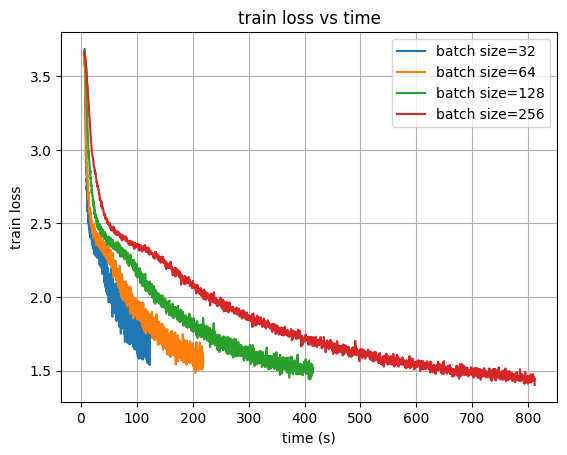

In [46]:
plt.figure()
for exp in experiment_results:
    b = exp['batch_size']
    t  = exp['train_time']
    L  = exp['train_loss']
    plt.plot(t, L, label=f"batch size={b:g}")

plt.xlabel("time (s)")
plt.ylabel("train loss")
plt.title("train loss vs time")
plt.legend()
plt.grid(True)
plt.show()


## **Experiment 1: Learning Rate (runtime = 2 min)**
#### Optimiser chosen: AdamW, plus gradient clipping
#### LR Schedule chosen: Cosine Decay with Warmup
##### **Other settings**:
For the experiments done below, the default model parameters were used (d_model=256, n_layers=2).


In [19]:
# ---- CONFIG ----
learning_rates = [1e-3, 1e-4, 1e-5]
runtime_limit = 120          # seconds (~2min)
full_niter = 100_000         # your true final planned training length
record_interval = 20
B, T = 128, 64
B_test, T_test = 1034, 32

experiment_results = []

# cosine warmup schedule (full schedule)
warmup_steps = int(0.1 * full_niter)
decay_steps  = full_niter - warmup_steps

def make_full_cosine(base_lr):
    def schedule(step):
        s = jnp.minimum(step, 1_000_000)
        warmup_lr = base_lr * (s / warmup_steps)
        cosine_decay = 0.5 * (1 + jnp.cos(jnp.pi * (s - warmup_steps) / decay_steps))
        cosine_lr = base_lr * cosine_decay
        return jnp.where(s < warmup_steps, warmup_lr, cosine_lr)
    return schedule


for lr in learning_rates:
    print(f"=== running lr={lr} ===")

    params_exp = params  # reset model

    schedule_fn = make_full_cosine(lr)
    tx = optax.chain(
        optax.clip_by_global_norm(1.0),
        optax.adamw(learning_rate=schedule_fn, weight_decay=1e-4)
    )
    opt_state_exp = tx.init(params_exp)

    # histories
    train_loss_history, train_acc_history, train_acc_last_history = [], [], []
    test_loss_history,  test_acc_history,  test_acc_last_history  = [], [], []
    lr_history = []
    time_history, time_test_history = [], []

    time_start = time.time()
    step = 0

    while time.time() - time_start < runtime_limit:

        # train batch
        input, target = get_batch(train_text_int, B, T)
        params_exp, opt_state_exp, metrics = train_step(params_exp, opt_state_exp, input, target, tx)

        # log train
        train_loss_history.append(float(metrics['loss']))
        train_acc_history.append(float(metrics['acc']))
        train_acc_last_history.append(float(metrics['acc_last']))
        time_history.append(time.time() - time_start)

        # numeric LR
        current_lr = float(schedule_fn(step))
        lr_history.append(current_lr)

        # periodic test
        if step % (record_interval * 5) == 0:
            test_input, test_target = get_batch(test_text_int, B_test, T_test)
            test_logits = model.apply({"params": params_exp}, test_input)
            test_loss, test_metrics = loss_and_metrics(test_logits, test_target)

            test_loss_history.append(float(test_loss))
            test_acc_history.append(float(test_metrics['acc']))
            test_acc_last_history.append(float(test_metrics['acc_last']))
            time_test_history.append(time.time() - time_start)

        step += 1

    print(f"done lr={lr} steps={step}")

    experiment_results.append({
        'lr': lr,
        'steps': step,
        'train_loss': train_loss_history,
        'train_acc': train_acc_history,
        'train_acc_last': train_acc_last_history,
        'test_loss': test_loss_history,
        'test_acc': test_acc_history,
        'test_acc_last': test_acc_last_history,
        'lr_history': lr_history,
        'train_time': time_history,
        'test_time': time_test_history
    })

=== running lr=0.001 ===
done lr=0.001 steps=3191
=== running lr=0.0001 ===
done lr=0.0001 steps=3266
=== running lr=1e-05 ===
done lr=1e-05 steps=3207


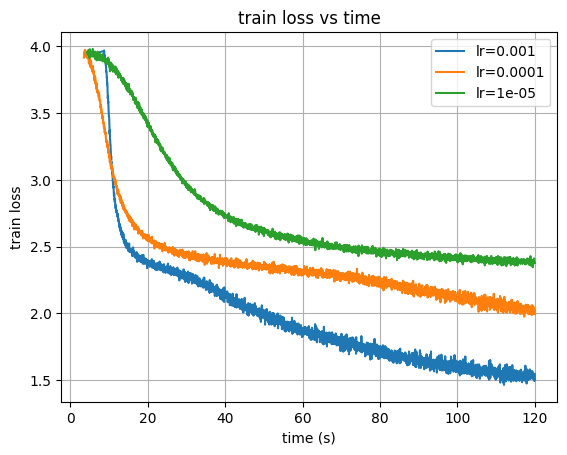

In [20]:
import matplotlib.pyplot as plt

plt.figure()
for exp in experiment_results:
    lr = exp['lr']
    t  = exp['train_time']
    L  = exp['train_loss']
    plt.plot(t, L, label=f"lr={lr:g}")

plt.xlabel("time (s)")
plt.ylabel("train loss")
plt.title("train loss vs time")
plt.legend()
plt.grid(True)
plt.show()

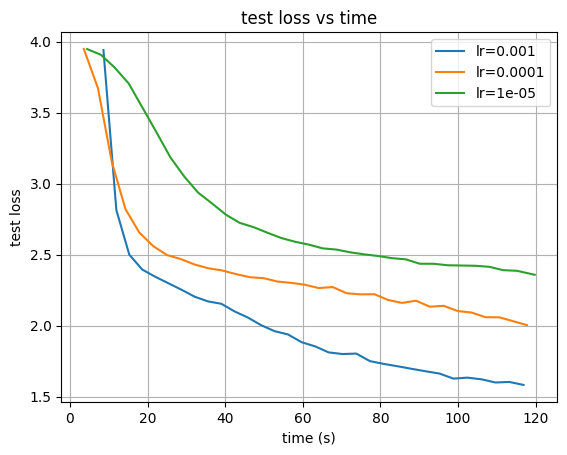

In [23]:
plt.figure()
for exp in experiment_results:
    lr = exp['lr']
    t  = exp['test_time']
    L  = exp['test_loss']
    plt.plot(t, L, label=f"lr={lr:g}")

plt.xlabel("time (s)")
plt.ylabel("test loss")
plt.title("test loss vs time")
plt.legend()
plt.grid(True)
plt.show()

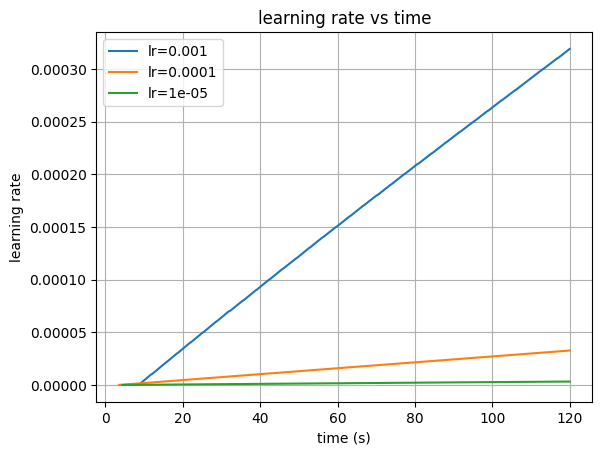

In [21]:
plt.figure()
for exp in experiment_results:
    lr = exp['lr']
    t  = exp['train_time']
    lr_hist = exp['lr_history']
    plt.plot(t, lr_hist, label=f"lr={lr:g}")

plt.xlabel("time (s)")
plt.ylabel("learning rate")
plt.title("learning rate vs time")
plt.legend()
plt.grid(True)
plt.show()

## **Experiment 1: Learning Rate (runtime = 10 min)**
learning_rates = [1e-3, 2e-3, 3e-3]

In [24]:
# ---- CONFIG ----
learning_rates = [1e-3, 2e-3, 3e-3]
runtime_limit = 600          # seconds (~2min)
full_niter = 100_000         # your true final planned training length
record_interval = 20
B, T = 128, 64
B_test, T_test = 1034, 32

experiment_results = []

# cosine warmup schedule (full schedule)
warmup_steps = int(0.1 * full_niter)
decay_steps  = full_niter - warmup_steps

def make_full_cosine(base_lr):
    def schedule(step):
        s = jnp.minimum(step, 1_000_000)
        warmup_lr = base_lr * (s / warmup_steps)
        cosine_decay = 0.5 * (1 + jnp.cos(jnp.pi * (s - warmup_steps) / decay_steps))
        cosine_lr = base_lr * cosine_decay
        return jnp.where(s < warmup_steps, warmup_lr, cosine_lr)
    return schedule


for lr in learning_rates:
    print(f"=== running lr={lr} ===")

    params_exp = params  # reset model

    schedule_fn = make_full_cosine(lr)
    tx = optax.chain(
        optax.clip_by_global_norm(1.0),
        optax.adamw(learning_rate=schedule_fn, weight_decay=1e-4)
    )
    opt_state_exp = tx.init(params_exp)

    # histories
    train_loss_history, train_acc_history, train_acc_last_history = [], [], []
    test_loss_history,  test_acc_history,  test_acc_last_history  = [], [], []
    lr_history = []
    time_history, time_test_history = [], []

    time_start = time.time()
    step = 0

    while time.time() - time_start < runtime_limit:

        # train batch
        input, target = get_batch(train_text_int, B, T)
        params_exp, opt_state_exp, metrics = train_step(params_exp, opt_state_exp, input, target, tx)

        # log train
        train_loss_history.append(float(metrics['loss']))
        train_acc_history.append(float(metrics['acc']))
        train_acc_last_history.append(float(metrics['acc_last']))
        time_history.append(time.time() - time_start)

        # numeric LR
        current_lr = float(schedule_fn(step))
        lr_history.append(current_lr)

        # periodic test
        if step % (record_interval * 5) == 0:
            test_input, test_target = get_batch(test_text_int, B_test, T_test)
            test_logits = model.apply({"params": params_exp}, test_input)
            test_loss, test_metrics = loss_and_metrics(test_logits, test_target)

            test_loss_history.append(float(test_loss))
            test_acc_history.append(float(test_metrics['acc']))
            test_acc_last_history.append(float(test_metrics['acc_last']))
            time_test_history.append(time.time() - time_start)

        step += 1

    print(f"done lr={lr} steps={step}")

    experiment_results.append({
        'lr': lr,
        'steps': step,
        'train_loss': train_loss_history,
        'train_acc': train_acc_history,
        'train_acc_last': train_acc_last_history,
        'test_loss': test_loss_history,
        'test_acc': test_acc_history,
        'test_acc_last': test_acc_last_history,
        'lr_history': lr_history,
        'train_time': time_history,
        'test_time': time_test_history
    })

=== running lr=0.001 ===
done lr=0.001 steps=16602
=== running lr=0.002 ===
done lr=0.002 steps=16765
=== running lr=0.003 ===
done lr=0.003 steps=16712


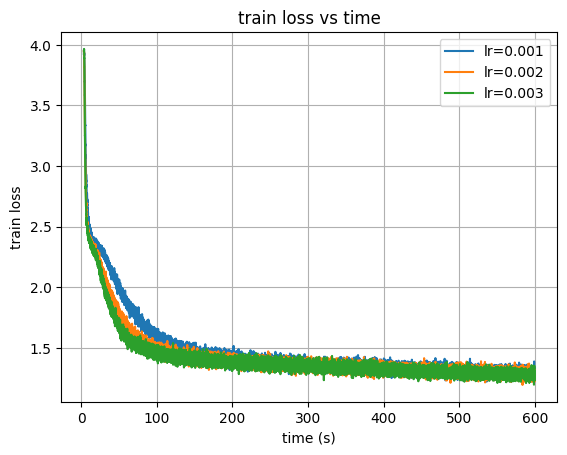

In [25]:
plt.figure()
for exp in experiment_results:
    lr = exp['lr']
    t  = exp['train_time']
    L  = exp['train_loss']
    plt.plot(t, L, label=f"lr={lr:g}")

plt.xlabel("time (s)")
plt.ylabel("train loss")
plt.title("train loss vs time")
plt.legend()
plt.grid(True)
plt.show()

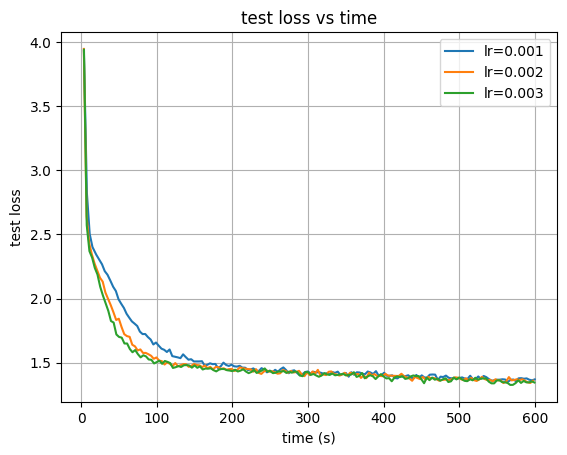

In [26]:
plt.figure()
for exp in experiment_results:
    lr = exp['lr']
    t  = exp['test_time']
    L  = exp['test_loss']
    plt.plot(t, L, label=f"lr={lr:g}")

plt.xlabel("time (s)")
plt.ylabel("test loss")
plt.title("test loss vs time")
plt.legend()
plt.grid(True)
plt.show()

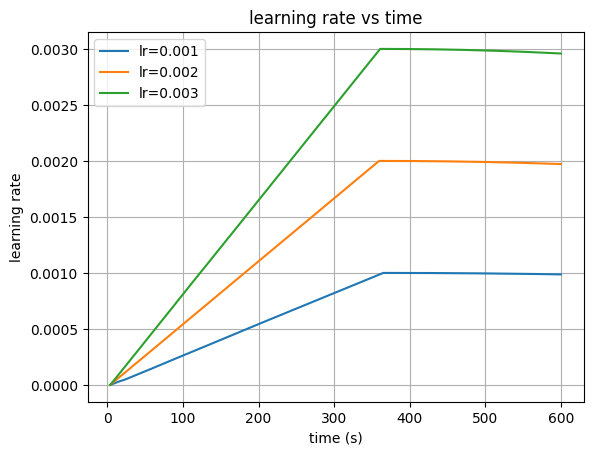

In [27]:
plt.figure()
for exp in experiment_results:
    lr = exp['lr']
    t  = exp['train_time']
    lr_hist = exp['lr_history']
    plt.plot(t, lr_hist, label=f"lr={lr:g}")

plt.xlabel("time (s)")
plt.ylabel("learning rate")
plt.title("learning rate vs time")
plt.legend()
plt.grid(True)
plt.show()

## **Experiment 1: Learning Rate (runtime = 10 min)**
learning_rates = [1e-3, 1e-4, 1e-5]



In [28]:
# ---- CONFIG ----
learning_rates = [1e-3, 1e-4, 1e-5]
runtime_limit = 600          # seconds (~10min)
full_niter = 100_000         # your true final planned training length
record_interval = 20
B, T = 128, 64
B_test, T_test = 1034, 32

experiment_results = []

# cosine warmup schedule (full schedule)
warmup_steps = int(0.1 * full_niter)
decay_steps  = full_niter - warmup_steps

def make_full_cosine(base_lr):
    def schedule(step):
        s = jnp.minimum(step, 1_000_000)
        warmup_lr = base_lr * (s / warmup_steps)
        cosine_decay = 0.5 * (1 + jnp.cos(jnp.pi * (s - warmup_steps) / decay_steps))
        cosine_lr = base_lr * cosine_decay
        return jnp.where(s < warmup_steps, warmup_lr, cosine_lr)
    return schedule


for lr in learning_rates:
    print(f"=== running lr={lr} ===")

    params_exp = params  # reset model

    schedule_fn = make_full_cosine(lr)
    tx = optax.chain(
        optax.clip_by_global_norm(1.0),
        optax.adamw(learning_rate=schedule_fn, weight_decay=1e-4)
    )
    opt_state_exp = tx.init(params_exp)

    # histories
    train_loss_history, train_acc_history, train_acc_last_history = [], [], []
    test_loss_history,  test_acc_history,  test_acc_last_history  = [], [], []
    lr_history = []
    time_history, time_test_history = [], []

    time_start = time.time()
    step = 0

    while time.time() - time_start < runtime_limit:

        # train batch
        input, target = get_batch(train_text_int, B, T)
        params_exp, opt_state_exp, metrics = train_step(params_exp, opt_state_exp, input, target, tx)

        # log train
        train_loss_history.append(float(metrics['loss']))
        train_acc_history.append(float(metrics['acc']))
        train_acc_last_history.append(float(metrics['acc_last']))
        time_history.append(time.time() - time_start)

        # numeric LR
        current_lr = float(schedule_fn(step))
        lr_history.append(current_lr)

        # periodic test
        if step % (record_interval * 5) == 0:
            test_input, test_target = get_batch(test_text_int, B_test, T_test)
            test_logits = model.apply({"params": params_exp}, test_input)
            test_loss, test_metrics = loss_and_metrics(test_logits, test_target)

            test_loss_history.append(float(test_loss))
            test_acc_history.append(float(test_metrics['acc']))
            test_acc_last_history.append(float(test_metrics['acc_last']))
            time_test_history.append(time.time() - time_start)

        step += 1

    print(f"done lr={lr} steps={step}")

    experiment_results.append({
        'lr': lr,
        'steps': step,
        'train_loss': train_loss_history,
        'train_acc': train_acc_history,
        'train_acc_last': train_acc_last_history,
        'test_loss': test_loss_history,
        'test_acc': test_acc_history,
        'test_acc_last': test_acc_last_history,
        'lr_history': lr_history,
        'train_time': time_history,
        'test_time': time_test_history
    })

=== running lr=0.001 ===
done lr=0.001 steps=16747
=== running lr=0.0001 ===
done lr=0.0001 steps=16743
=== running lr=1e-05 ===
done lr=1e-05 steps=16636


In [34]:
print("\n=== Experiment Summary (Final Test Performance) ===")
for exp in experiment_results:
    final_test_loss = exp['test_loss'][-1] if exp['test_loss'] else None
    final_test_acc = exp['test_acc'][-1] * 100 if exp['test_acc'] else None
    final_test_acc_last = exp['test_acc_last'][-1] * 100 if exp['test_acc_last'] else None
    print(f"LR={exp['lr']:<8}"
          f"| Test Loss={final_test_loss:.4f} | Test Acc={final_test_acc:.2f}% | Test Acc (Last Char)={final_test_acc_last:.2f}%")


=== Experiment Summary (Final Test Performance) ===
LR=0.001   | Test Loss=1.3538 | Test Acc=57.64% | Test Acc (Last Char)=58.03%
LR=0.0001  | Test Loss=1.4372 | Test Acc=55.64% | Test Acc (Last Char)=54.45%
LR=1e-05   | Test Loss=1.8176 | Test Acc=44.66% | Test Acc (Last Char)=45.16%


Based on the results above, LR=0.001 has the best test loss (1.35) and test accuracy (57.6%). However, since the training schedule includes a cosine decay with warmup and we only ran the experiments for 10 minutes, the chosen learning rate primarily reflects the early-stage behavior of the model. The apparent superiority of LR=0.001 may be influenced by the warmup phase and the initial portion of the cosine decay, and longer training could shift the optimal learning rate, as slower or faster decay dynamics may lead to different convergence patterns or generalisation performance.

Also, all variants of Experiment 1 did not consider tuning other parameters (e.g. *model_d*, *n_layers*). All parameters were kept constant except *learning_rate*.

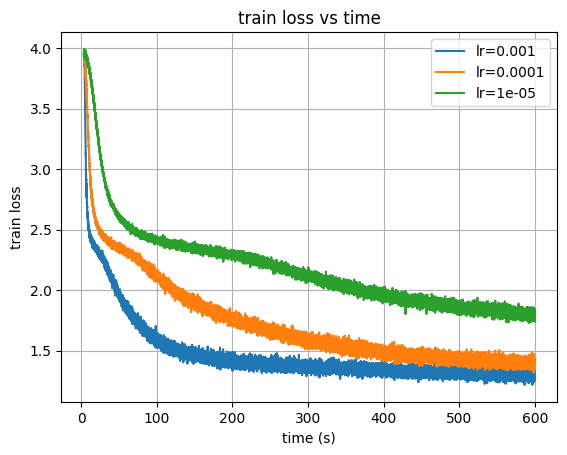

In [29]:
plt.figure()
for exp in experiment_results:
    lr = exp['lr']
    t  = exp['train_time']
    L  = exp['train_loss']
    plt.plot(t, L, label=f"lr={lr:g}")

plt.xlabel("time (s)")
plt.ylabel("train loss")
plt.title("train loss vs time")
plt.legend()
plt.grid(True)
plt.show()

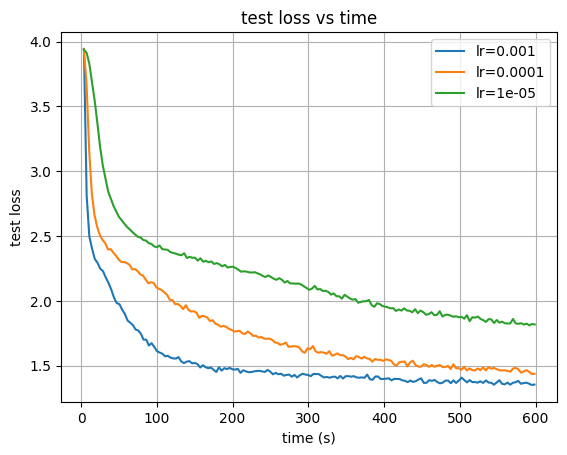

In [30]:
plt.figure()
for exp in experiment_results:
    lr = exp['lr']
    t  = exp['test_time']
    L  = exp['test_loss']
    plt.plot(t, L, label=f"lr={lr:g}")

plt.xlabel("time (s)")
plt.ylabel("test loss")
plt.title("test loss vs time")
plt.legend()
plt.grid(True)
plt.show()

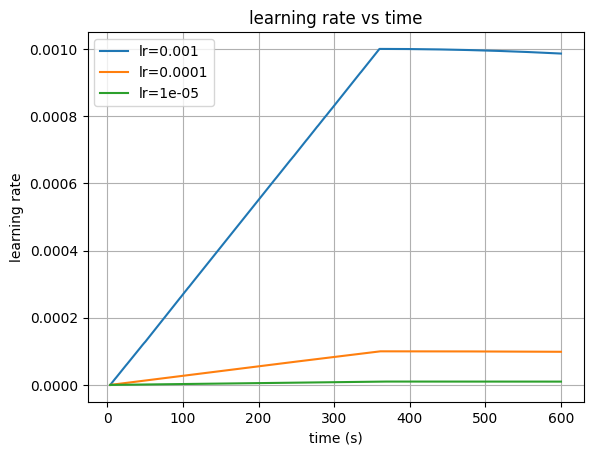

In [31]:
plt.figure()
for exp in experiment_results:
    lr = exp['lr']
    t  = exp['train_time']
    lr_hist = exp['lr_history']
    plt.plot(t, lr_hist, label=f"lr={lr:g}")

plt.xlabel("time (s)")
plt.ylabel("learning rate")
plt.title("learning rate vs time")
plt.legend()
plt.grid(True)
plt.show()

In [22]:
# B = 1
# seed = 42
# rng = jax.random.PRNGKey(seed)
# prompt = "hello my fri"
# # prompt_int = encode(prompt.lower())
# prompt_int = jnp.array([ [char_to_int.get(c, len(char_set)) for c in prompt.lower()[:64]] ], dtype=jnp.int32)

# gen_len = 1000
# out_ids = generation.generate_tokens(model, params, rng, prompt_int, gen_len, block_size=64,
#                           temperature=0.7, sample=True)
# print('generated ids shape:', out_ids.shape)
# print('generated text:')
# generated_text = ''.join(int_to_char.get(int(x), '?') for x in list(out_ids[0]))
# # concatenate with prompt
# print(prompt + generated_text)
# #print(''.join(int_to_char.get(int(x), '?') for x in list(out_ids[0])))